In [2]:
import numpy as np
import scipy
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from utils import JacobiGL, constructD
import numpy.typing as npt

%load_ext autoreload
%autoreload 2

# a)
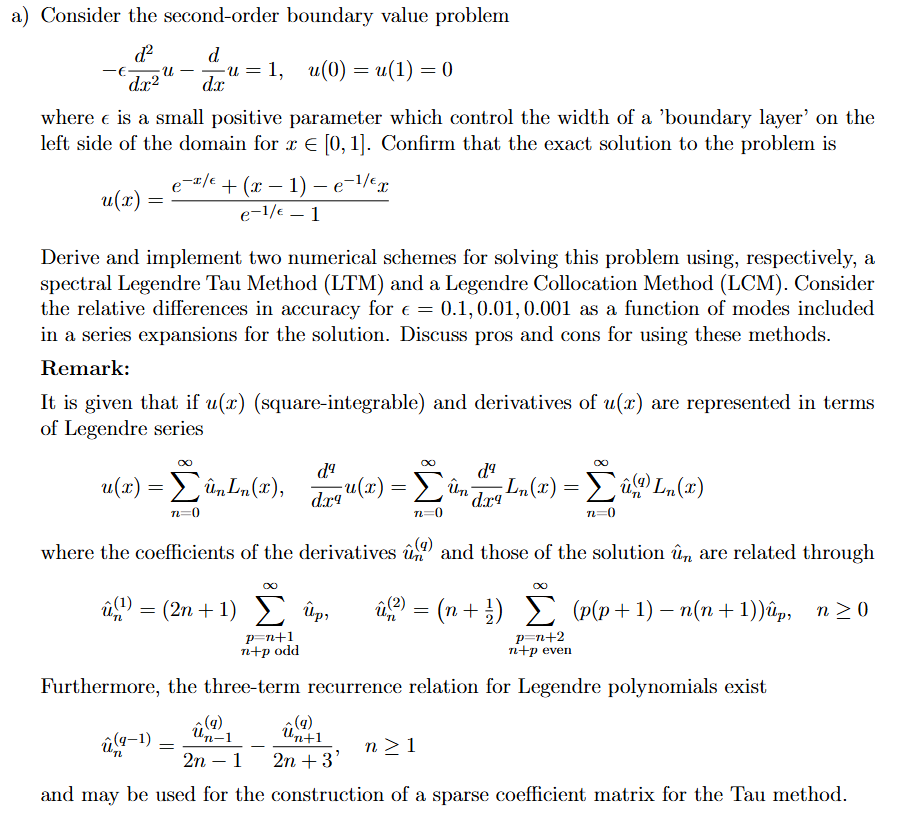

In [3]:
def u_func_1(x, epsilon):
    denom = np.exp(-1.0 / epsilon) - 1
    nom = (
        + np.exp(-x / epsilon)
        + (x - 1)
        - np.exp(-1/epsilon) * x
    )
    return nom / denom

# Legendre
alpha = 0.0
beta = 0.0

# Let z be Jacobi domain, z ∈ [-1, 1]
a, b = 0.0, 1.0  # Domain


def jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Evaluates first `n+1` Jacobi polynomials at points `x` with parameters `alpha` and `beta`.
    Reflects L2, slide 12.

    Arguments:
        x: Points at which to evaluate the polynomials, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)

    Returns: Array of shape (m, n+1) where each column corresponds to a Jacobi polynomial
        Note that this is essentially the Vandermonde matrix for Jacobi polynomials.
    """
    assert n >= 0, "n must be non-negative"

    P = np.empty((len(x), n + 1))

    P[:, 0] = 1.0
    if n == 0:
        return P

    P[:, 1] = 1 / 2 * (alpha - beta + (alpha + beta + 2) * x)
    if n == 1:
        return P

    for k in range(1, n):
        a_nm1_n = (
            2
            * (k + alpha)
            * (k + beta)
            / ((2 * k + alpha + beta + 1) * (2 * k + alpha + beta))
        )
        a_n_n = (alpha**2 - beta**2) / (
            (2 * k + alpha + beta + 2) * (2 * k + alpha + beta)
        )
        a_np1_n = (
            2
            * (k + 1)
            * (k + alpha + beta + 1)
            / ((2 * k + alpha + beta + 2) * (2 * k + alpha + beta + 1))
        )

        P[:, k + 1] = ((a_n_n + x) * P[:, k] - a_nm1_n * P[:, k - 1]) / a_np1_n

    return P


def grad_jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Computes the gradient of the first `n+1` Jacobi polynomials at nodes `x`.
    Reflects L2, slide 15.

    Arguments:
        x: Points at which to evaluate the gradients, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)
    Returns: Array of shape (m, n+1) where each column corresponds to the gradient of a Jacobi polynomial
    """
    grad_p = np.empty((len(x), n + 1))

    for i in range(n + 1):
        if i == 0:
            p_i = np.zeros_like(x)
        else:
            p_i = jacobi_p(x, alpha + 1, beta + 1, i - 1)[:, i - 1]

        coeff = 1 / 2 * (alpha + beta + i + 1)
        grad_p[:, i] = coeff * p_i

    return grad_p


# Legend

## a - Spectral Legendre Tau Method

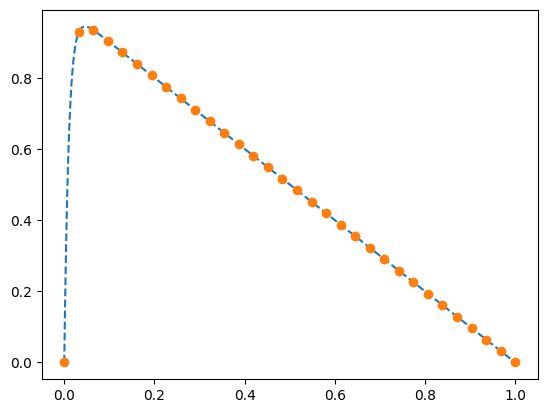

In [ ]:
# We first solve Spectral Legendre Tau Method
N = 32
P = N - 1
epsilon = 0.01

# Build system matrix, L_N
a_coeff = -4.0 * epsilon
b_coeff = -2.0
c_coeff = 0.0

# Construct differentiation matrix
D = np.zeros((N, N))
for n in range(N):
    e_n = np.zeros(N)
    e_n[n] = 1.0

    # Use basis vectors as u_hat
    u_hat = e_n
    u_prime_hat = np.zeros_like(u_hat)

    # Correct Legendre differentiation rule:
    # u'_k = (2k+1) * sum_{p=k+1, p-k is odd}^N u_p
    for k in range(N):
        sum_val = 0.0
        for p in range(k + 1, N):
            if (p - k) % 2 == 1:
                sum_val += u_hat[p]
        u_prime_hat[k] = (2 * k + 1) * sum_val

    D[:, n] = u_prime_hat

L_N = a_coeff * D @ D + b_coeff * D + c_coeff * np.eye(N)
L_N.shape

# Construct A matrix where we sacrifice some rows for BCs
A = L_N.copy()
A[N-2, :] = [1.0 for _ in range(N)]
A[N-1, :] = [(-1)**n for n in range(N)]

# Now build RHS
f_hat = np.zeros(N)
f_hat[0] = 1.0
f_hat[N-2] = 0.0
f_hat[N-1] = 0.0
# D = constructD(z, alpha, beta)

# Now solve for coefficients
u_hat = np.linalg.solve(A, f_hat)

# And evaluate Legendre polynomial with these at points
x_eval = np.linspace(0, 1, N, endpoint=True)
z_eval = 2 * x_eval - 1  # Map to [-1, 1]

legendre_poly = np.polynomial.legendre.Legendre(u_hat)
u_hat = legendre_poly(z_eval)

# Now plot
x = np.linspace(0, 1, 500)
u_true = u_func_1(x, epsilon)

x_eval = np.linspace(0, 1, N, endpoint=True)

plt.plot(x, u_true, label='Exact solution', linestyle='dashed')
plt.plot(x_eval, u_hat, "o")


## a - Legendre Collocation Method

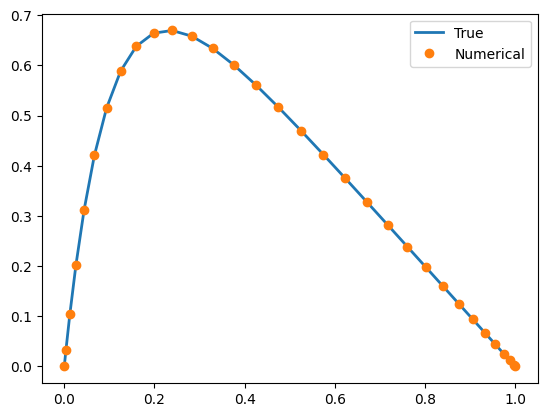

In [10]:
N = 32
P = N - 1

# Model parameters
epsilon = 0.1

z_gl = JacobiGL(alpha, beta, P)  # Includes boundaries, domain: [-1, 1]
x_gl = 0.5 * (b - a) * (z_gl + 1) + a  # Map to [a, b]
u_gl_true = u_func_1(x_gl, epsilon)

D_z = constructD(z_gl, alpha, beta)
# D_x = transform_dz_to_dx(z_gl, a, b) * D_z  # Chain rule

A = -4.0 * epsilon * np.eye(N)
B = -2.0 * np.eye(N)
C = np.zeros((N, N))

# Set up approximate operator
L_N = D_z @ A @ D_z + B @ D_z  + C

# RHS
F = np.ones(N)

# Enforce BCs
L_N[0, :] = 0.0
L_N[0, 0] = 1.0
L_N[-1, :] = 0.0
L_N[-1, -1] = 1.0
F[0] = 0.0
F[-1] = 0.0

# Solve
u_gl = np.linalg.solve(L_N, F)

plt.plot(x_gl, u_gl_true, lw=2, label='True')
plt.plot(x_gl, u_gl, "o", label='Numerical')
plt.legend()


# b)
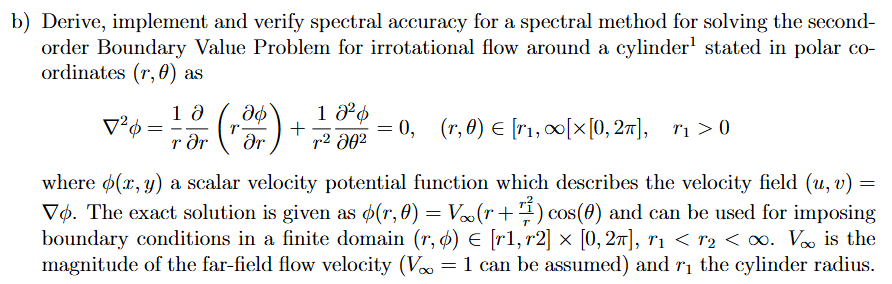